In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', None)

In [4]:
# Read in the data
df = pd.read_csv(r'C:\Users\GTR\Documents\GitHub\Car_Sales_Project_1\project\ETL_data\vehicles_clean.csv')

In [156]:
numeric_features = ['year', 'cylinders', 'kilometre', 'title_status_num', 'condition_num']

# 1.Preparing data

## 1.1 remove outliers

In [184]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
iqr = Q3 - Q1
lower_limit = Q1 - (1.5 * iqr)
upper_limit = Q3 + (1.5 * iqr)
df = df.loc[(df['price'] >= lower_limit) & (df['price'] <= upper_limit)]

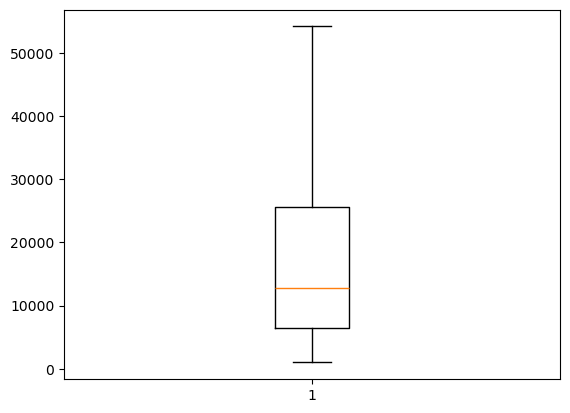

In [185]:
plt.boxplot(df['price'])
plt.show()

## 1.2 Transform data

In [19]:
# remove model, description, posting_date, condition, region, title_status columns
df_model = df.drop(columns=['model', 'description', 'posting_date','condition','region','title_status'])
# convert condition car to numerical value
condition_mapping = {'new': 6, 'like new': 5, 'excellent': 4, 'good': 3, 'fair': 2, 'salvage': 1}
df_model['condition_num'] = df['condition'].map(condition_mapping)
# convert title_status to numerical value
title_status_mapping = {'clean': 6, 'rebuilt': 5, 'lien': 4, 'salvage': 3, 'missing': 2, 'parts only': 1}
df_model['title_status_num'] = df['title_status'].map(title_status_mapping)
# replace other with 0 
df_model.loc[df_model['cylinders']=='other', 'cylinders'] = 0
# convert cylinders to numerical value
df_model['cylinders'] = df_model['cylinders'].astype(int)
# reorganize columns
df_model = df_model[['year', 'state','manufacturer', 'cylinders', 'fuel', 'kilometre', 'transmission', 'type', 'paint_color', 'title_status_num', 'condition_num', 'price']]

## 1.3 Spliting data 

In [148]:
# Split the data into features (X) and target variable (y)
X = df_model.drop('price', axis=1)
y = df_model['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
# reset index
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## 1.4 Normalizing data

In [150]:
# Normalize the numeric columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.fit_transform(X_test[numeric_features])

X_train[numeric_features] = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_test[numeric_features] = pd.DataFrame(X_test_scaled, columns=numeric_features)

## 1.5 Encoding categoricale data 

### 1.5.1 Binary encoder

In [157]:
# Initialize and fit the BinaryEncoder
encoder = BinaryEncoder(cols=['state', 'manufacturer','fuel','transmission','type','paint_color'])
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

### 1.5.2 Hot One Encoder

In [168]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the categorical columns
encoded_features = encoder.fit_transform(X_train[['state', 'manufacturer','fuel','transmission','type','paint_color']])
encoded_features_test = encoder.fit_transform(X_test[['state', 'manufacturer','fuel','transmission','type','paint_color']])
# Create a DataFrame with the one-hot encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['state', 'manufacturer','fuel','transmission','type','paint_color']))
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(['state', 'manufacturer','fuel','transmission','type','paint_color']))

# Concatenate the one-hot encoded features with the original DataFrame
X_train_encoded = pd.concat([X_train[['year', 'cylinders', 'kilometre', 'title_status_num', 'condition_num']], encoded_df], axis=1)
X_test_encoded = pd.concat([X_test[['year', 'cylinders', 'kilometre', 'title_status_num', 'condition_num']], encoded_df_test], axis=1)

c:\Users\GTR\miniconda3\envs\da311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\GTR\miniconda3\envs\da311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 2. Training and prediction

In [169]:
from sklearn.ensemble import RandomForestRegressor
# Initialize and train a model (Random Forest Regressor in this case)
model = RandomForestRegressor(random_state=42)
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1881.2547227723758


In [170]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 5798.106298307092


In [171]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 2284.858894022388


In [172]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3482.747931652656


In [173]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 5194.077654295674


In [174]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 5802.7134860687


In [179]:
from sklearn.linear_model import ElasticNet
model = ElasticNet()
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 9052.696113180205


In [180]:
from sklearn.linear_model import HuberRegressor
model = HuberRegressor()
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 5433.63358727668


c:\Users\GTR\miniconda3\envs\da311\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [181]:
import xgboost as xgb
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)  # 'reg:squarederror' for regression
# Train the model
model.fit(X_train_encoded, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 2609.67
